In [63]:
# === NLP & Text Processing ===
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# === Core Libraries ===
import os
import sys
import math
import re
import warnings
from pathlib import Path
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

# === Statistics ===
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.linalg as _sla

# === Machine Learning ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [65]:
df = pd.read_csv("Datasets/train_dataset.csv", encoding="latin1")
df.drop(columns=["selected_text"], inplace=True)
df.drop(columns=["Population -2020"], inplace=True)
df.drop(columns=["Land Area (Km²)"], inplace=True)
df.drop(columns=["Density (P/Km²)"], inplace=True)
df.to_csv("Datasets/clean_train.csv", index=False, encoding="latin1")
print(df.shape)
df.head()
df["Country"].nunique()
print(df['sentiment'].value_counts())
print(df["sentiment"].value_counts(normalize=True) * 100)

(27481, 6)
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64
sentiment
neutral     40.457043
positive    31.228849
negative    28.314108
Name: proportion, dtype: float64


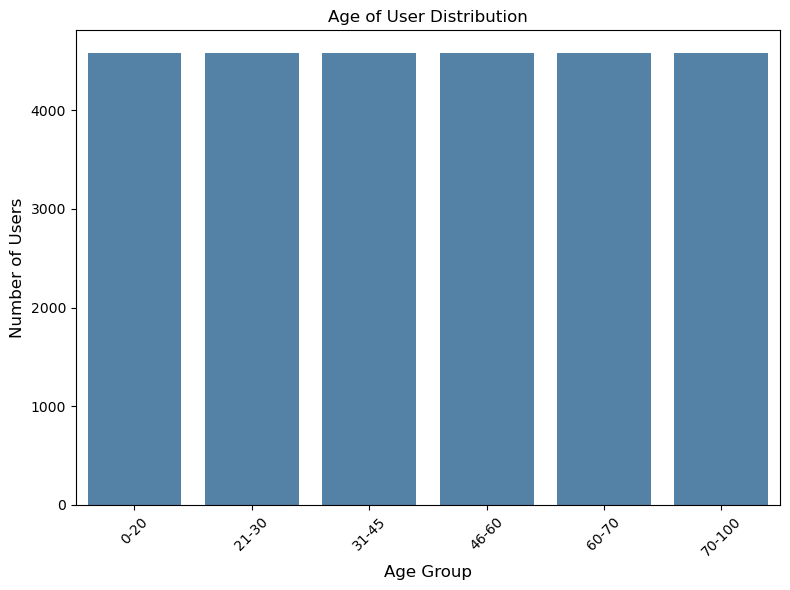

In [10]:
df = pd.read_csv("Datasets/train_dataset.csv", encoding="latin1")

df["Age of User"] = df["Age of User"].astype(str).str.strip()

age_counts = df["Age of User"].value_counts().sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=age_counts.index, y=age_counts.values, color="steelblue")

plt.title("Age of User Distribution", fontsize=12)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

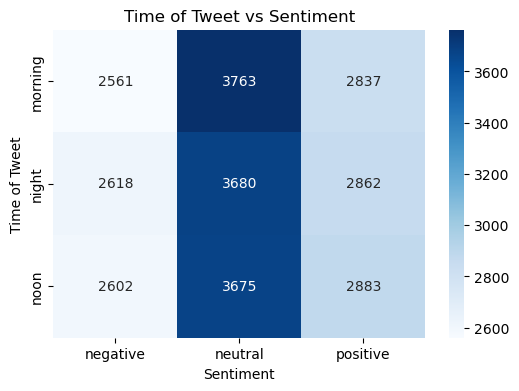

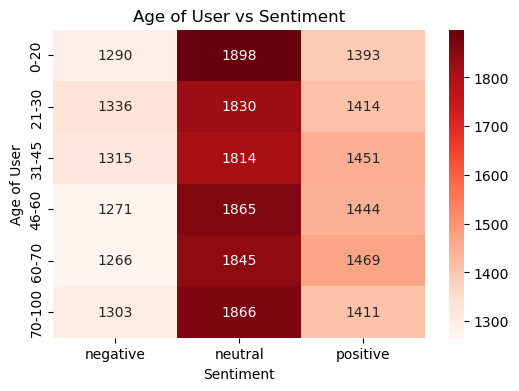

In [26]:
ct = pd.crosstab(df["Time of Tweet"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Time of Tweet vs Sentiment")
plt.ylabel("Time of Tweet")
plt.xlabel("Sentiment")
plt.show()

ct = pd.crosstab(df["Age of User"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Reds")
plt.title("Age of User vs Sentiment")
plt.ylabel("Age of User")
plt.xlabel("Sentiment")
plt.show()

Mevcut sınıflar: ['neg', 'neu', 'pos']

=== Classification Report (Word2Vec avg + LinearSVC) ===
              precision    recall  f1-score   support

         neg      0.583     0.594     0.589      1556
         neu      0.580     0.586     0.583      2223
         pos      0.675     0.654     0.664      1717

    accuracy                          0.610      5496
   macro avg      0.613     0.611     0.612      5496
weighted avg      0.610     0.610     0.610      5496

Overall Accuracy: 0.6095


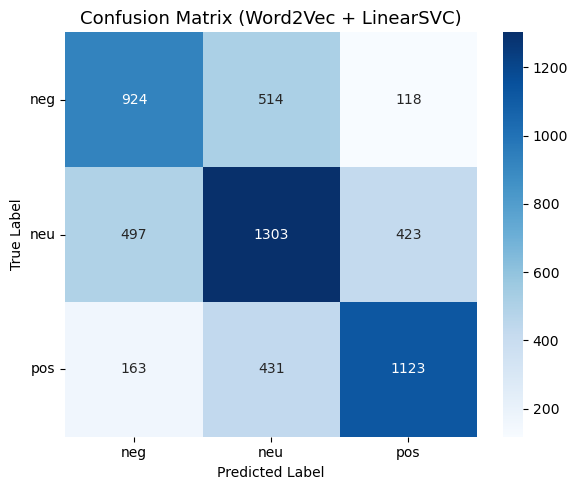

In [67]:
# === Word2Vec Embeddings (avg) + LinearSVC (text-only) ===

def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)


X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"],
    test_size=0.2, random_state=42, stratify=df["sentiment"]
)


class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    fit(): yalnızca X_train üzerinde Word2Vec modeli eğitir.
    transform(): her doküman için ortalama kelime vektörü döndürür.
    """
    def __init__(self, size=100, window=5, min_count=2, epochs=10, sg=1, workers=4, seed=42):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.sg = sg             # 1: Skip-gram, 0: CBOW
        self.workers = workers
        self.seed = seed
        self.model_ = None

    def _tokenize(self, text):
        return simple_preprocess(str(text), deacc=False, min_len=1, max_len=100)

    def fit(self, X, y=None):
        sentences = [self._tokenize(t) for t in X]
        self.model_ = Word2Vec(
            vector_size=self.size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            seed=self.seed
        )
        self.model_.build_vocab(sentences)
        self.model_.train(sentences, total_examples=len(sentences), epochs=self.epochs)
        return self

    def transform(self, X):
        def doc_vec(tokens):
            vecs = [self.model_.wv[w] for w in tokens if w in self.model_.wv]
            if not vecs:
                return np.zeros(self.size, dtype=np.float32)
            return np.mean(vecs, axis=0)
        docs = [self._tokenize(t) for t in X]
        M = np.vstack([doc_vec(toks) for toks in docs])
        return M


w2v_svm = Pipeline([
    ("w2v", Word2VecVectorizer(size=100, window=5, min_count=2, epochs=10, sg=1, workers=4, seed=42)),
    ("svm", LinearSVC(C=1, class_weight="balanced", random_state=42)),
])

w2v_svm.fit(X_train, y_train)
y_pred = w2v_svm.predict(X_test)

label_order = ["neg", "neu", "pos"]  # varsa mevcut sırana göre ayarla
print("\n=== Classification Report (Word2Vec avg + LinearSVC) ===")
print(classification_report(y_test, y_pred, labels=present, digits=3))
print("Overall Accuracy:", round(accuracy_score(y_test, y_pred), 4))

cm = confusion_matrix(y_test, y_pred, labels=label_order)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_order, yticklabels=label_order, ax=ax)
ax.set_title("Confusion Matrix (Word2Vec + LinearSVC)", fontsize=13)
ax.set_xlabel("Predicted Label"); ax.set_ylabel("True Label")
plt.xticks(rotation=0); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

Mevcut sınıflar: ['neg', 'neu', 'pos']

=== MultinomialNB Classification Report ===
              precision    recall  f1-score   support

         neg      0.582     0.584     0.583      1556
         neu      0.587     0.605     0.596      2223
         pos      0.687     0.657     0.672      1717

    accuracy                          0.615      5496
   macro avg      0.619     0.615     0.617      5496
weighted avg      0.617     0.615     0.616      5496

Overall Accuracy: 0.615


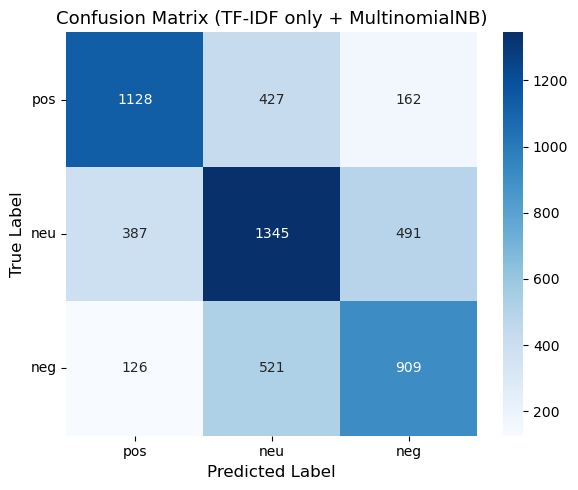

In [48]:
# TF-IDF Naive Bayes #

def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)

nb_clf = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("nb",    MultinomialNB(alpha=1.0))  # alpha: Laplace/Lidstone smoothing
])

# === Classification Report ===
print("\n=== MultinomialNB Classification Report ===")
print(classification_report(y_test, y_pred, labels=["neg", "neu", "pos"], digits=3))
print("Overall Accuracy:", round(accuracy_score(y_test, y_pred), 3))

label_order = ["neg", "neu", "pos"]

cm = confusion_matrix(y_test, y_pred, labels=label_order)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order,
    ax=ax
)

ax.set_title("Confusion Matrix (TF-IDF only + MultinomialNB)", fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.invert_xaxis()

ax.invert_yaxis()

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


=== VADER Classification Report ===
              precision    recall  f1-score   support

    negative      0.699     0.596     0.644      7781
     neutral      0.704     0.472     0.565     11117
    positive      0.557     0.870     0.679      8582

    accuracy                          0.631     27480
   macro avg      0.653     0.646     0.629     27480
weighted avg      0.657     0.631     0.623     27480

Overall Accuracy: 0.631


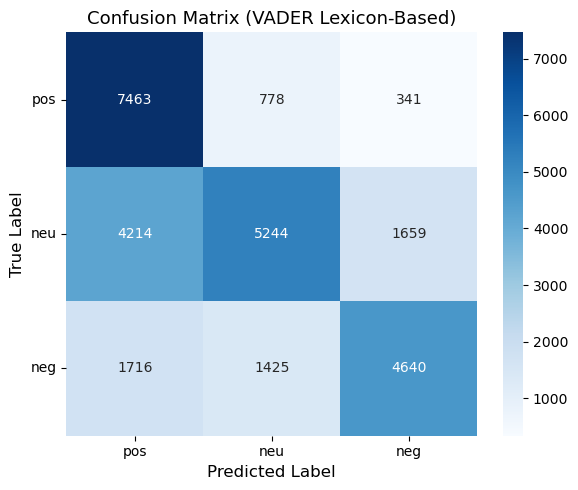

In [13]:
## VADER Analyzer

sia = SentimentIntensityAnalyzer()

df["sentiment_scores"] = df["text"].apply(lambda x: sia.polarity_scores(str(x)))

def vader_label(score_dict):
    c = score_dict["compound"]
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_found"] = df["sentiment_scores"].apply(vader_label)

df.to_csv("Datasets/sentiment_lexicon-based.csv", index=False, encoding="latin1")

true_labels = df["sentiment"].map(str.lower).replace({
    "pos": "positive", "neg": "negative", "neu": "neutral"
})
pred_labels = df["sentiment_found"]

label_order = ["negative", "neutral", "positive"]

print("\n=== VADER Classification Report ===")
print(classification_report(true_labels, pred_labels, labels=label_order, digits=3))
print("Overall Accuracy:", round(accuracy_score(true_labels, pred_labels), 3))

true_labels = true_labels.str.lower().replace({
    "positive": "pos",
    "negative": "neg",
    "neutral": "neu"
})

pred_labels = pred_labels.str.lower().replace({
    "positive": "pos",
    "negative": "neg",
    "neutral": "neu"
})

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_order = ["neg", "neu", "pos"]  # orijinal sıra
cm = confusion_matrix(true_labels, pred_labels, labels=label_order)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order,
    ax=ax
)

ax.set_title("Confusion Matrix (VADER Lexicon-Based)", fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.invert_xaxis()

ax.invert_yaxis()

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()